In [1]:
import os, torch
os.chdir("/Users/ESKO/PYWORK/NHITS")
print(os.getcwd())

C:\Users\ESKO\anaconda3\envs\dl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\ESKO\PYWORK\NHITS


In [2]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from ray import tune
from sklearn.preprocessing import StandardScaler

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoTFT
from neuralforecast.models import NBEATS, NBEATSx, NHITS, TFT
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, GMM, PMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.losses.pytorch import MAE

## <기준날짜 및 예측 기간 설정>

In [283]:
cutoff_date = '2022-01-31' ## len = 65
test_period =  11 ## 예측 기간 (월)
corr_rate = 0.70 ## Lag corr rate
future_variable_limit = 5

## <원 data set>

In [284]:
df = pd.read_csv('./data/metal_pst.csv')
df.rename(columns={'date':'ds'},inplace=True)
df.rename(columns={'li2co3_cif_fast_kg_spot_exchng':'y'},inplace=True)
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')

raw_y_set_resampled = df.copy()
raw_y_set_resampled.rename(columns={'ds':'date'},inplace=True)
raw_y_set_resampled.rename(columns={'lioh_cif_fast_kg_spot_exchng':'y2'},inplace=True)
del raw_y_set_resampled['unique_id']

## Feature shift 12개월

In [285]:
%%time

raw_y_set_resampled = raw_y_set_resampled[raw_y_set_resampled.date<=cutoff_date]
raw_y_set_shifted_merged = raw_y_set_resampled['date']

for i in range(len(raw_y_set_resampled.columns)):
    if i == len(raw_y_set_resampled.columns) - 1:
        break
    raw_y_set_shifted = raw_y_set_resampled.iloc[:,[0,i+1]].dropna()
    for j in range(10,13):
        raw_y_set_shifted = pd.concat([raw_y_set_shifted, (raw_y_set_shifted.iloc[:,1].shift(j+1).rename(raw_y_set_resampled.columns[i+1] + '_' +str(j+1)))],axis=1)
        raw_y_set_shifted_merged = pd.merge(raw_y_set_shifted_merged, raw_y_set_shifted, how= 'outer') 
        if j == len(raw_y_set_shifted.iloc[:,1]) -2 :
            break
# raw_y_set_shifted_merged.to_csv('./data/raw_y_set_shifted_merged.csv', encoding='cp949')

CPU times: total: 1min 11s
Wall time: 4min 23s


#### 해당 기간에서의 12 lag corr best

In [286]:
raw_y_set_shifted_merged_corr = raw_y_set_shifted_merged.corr()
raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_corr[raw_y_set_resampled.columns.drop('date')]
raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_filtered.loc[raw_y_set_shifted_merged_filtered.index != 'y']
raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_filtered.loc[raw_y_set_shifted_merged_filtered.index != 'y2']
raw_y_set_shifted_merged_filtered_y = raw_y_set_shifted_merged_filtered.iloc[:,:1]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_y[raw_y_set_shifted_merged_filtered_y.y >= corr_rate]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate[raw_y_set_shifted_merged_filtered_upto_corr_rate.index.str.contains('_12')]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate.sort_values('y',ascending=False)

if len(raw_y_set_shifted_merged_filtered_upto_corr_rate) >= 20:
    raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate[:future_variable_limit]
else:
    pass

futr_list = raw_y_set_shifted_merged_filtered_upto_corr_rate.index.values.tolist()

futr_list = [word.replace("_12", "") for word in futr_list]
if 'y2' in futr_list:
    (futr_list).remove('y2')
else:
    pass

# futr_list

futr_list

['CLI_KOR', 'PPP_CZE']

#### 해당 기간에서의 12 corr best

In [287]:
hist_var_chcek = raw_y_set_resampled.iloc[:,1:]

hist_var_corr = hist_var_chcek.corr()
hist_var_corr_filtered = hist_var_corr.loc[hist_var_corr.index != 'y']
hist_var_corr_filtered = hist_var_corr_filtered.loc[hist_var_corr_filtered.index != 'y2']
hist_var_corr_filtered_y = hist_var_corr_filtered.iloc[:,:1]
hist_var_corr_filtered_y_corr_rate = hist_var_corr_filtered_y[hist_var_corr_filtered_y.y >= corr_rate]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_corr_rate[hist_var_corr_filtered_y_corr_rate.index.str.contains('li2co3')==False]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_only[hist_var_corr_filtered_y_only.index.str.contains('lioh')==False]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_only.sort_values('y',ascending=False)
hist_var_list = hist_var_corr_filtered_y_only.index.values.tolist()

hist_var_list

['CPI_KOR_TOT_FOODENRG_AGRWTH',
 'CPI_BEL_TOT_AGRWTH',
 'CPI_PRT_TOT_FOODENRG_AGRWTH',
 '대두 [미국(생산자 가격)] 현물',
 'al_lme_kg',
 'CPI_COL_ENRG_AGRWTH',
 'BCI_CAN',
 'CPI_BEL_ENRG_AGRWTH',
 'CPI_PRT_TOT_AGRWTH',
 'BCI_CRI',
 'CLI_IRL',
 'CPI_COL_TOT_AGRWTH']

## scaler

In [243]:
# df_tgt = df.iloc[:,3:]

# scaler = StandardScaler()
# scaler.fit(df_tgt)
# arr = scaler.transform(df_tgt)
# df_tmp = pd.DataFrame(arr, columns=df_tgt.columns)
# df = pd.concat([df.iloc[:,:3],df_tmp], axis=1)

#### static DF

In [244]:
static_df = pd.read_csv('/users/ESKO/PYWORK/NHITS/data/static_df.csv')

## <Training & Test>

#### 날짜 확인

In [245]:
# train = df.loc[df.ds < '2021-06-30']
# test = df.loc[df.ds > '2021-06-30']

#### 날짜 별 len 확인

In [246]:
# len(df.loc[df.ds<'2021-06-30'])

In [247]:
# len(Y_train_df)
# len(Y_test_df)
# len(df)

In [288]:
Y_train_df = df[df.ds<=cutoff_date]
Y_test_df = df[df.ds>cutoff_date]
# Y_train_df = df[df.ds<df['ds'].values[len(df.loc[df.ds<=cutoff_date])]]
# Y_test_df = df[df.ds>=df['ds'].values[len(df.loc[df.ds<=cutoff_date])]]

In [289]:
futr_temp = Y_test_df.drop(['y'], axis=1).copy()
# futr_list = [
#              'Shanghai Containerized Freight Index (SCFI)',
#              '대두 [미국(생산자 가격)] 현물',
#              # '대두유 crude and refined average price [파라나구아(FOB)] 현물',
#              '보일러용 후판 Q245R 30mm Xinyu Steel [중국] 현물',
#              # 'HOUSECOST_KOR'
#              ]
futr_date = futr_temp.iloc[:,:2].copy()
futr_df = pd.concat([futr_date, futr_temp[futr_list]], axis=1)
# futr_df

#### No 변수

In [198]:
horizon = len(Y_test_df)

models = [
          # NBEATS(input_size=5 * horizon, gpus = 1, h=horizon, max_epochs=100),
          # NBEATSx(h=12, input_size=24,
          #       # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #       gpus=1,
          #       scaler_type='robust',
          #       stat_exog_list = None,  
          #       futr_exog_list = futr_list,
          #       max_steps=100,
          #       # val_check_steps=10,
          #       # early_stop_patience_steps=2
          #      ),
          NHITS(input_size=5 * horizon, 
                h=horizon+1,
                gpus = 1,
                stat_exog_list = None,
                hist_exog_list=None,
                futr_exog_list = None,
                # futr_exog_list = futr_list,
                # n_freq_downsample=[24, 12, 1],
                # mlp_units = [[512, 512], [512, 512], [512, 512]],
                # n_pool_kernel_size = [2, 2, 1],
                # n_freq_downsample=[24, 12, 1],
                scaler_type = 'standard',
                learning_rate=1e-4,
                pooling_mode = 'MaxPool1d',
                activation='ReLU',
                batch_size=128,
                random_seed=42,
                max_epochs=200
               ),
           # NHITS(
           #       h,
           #       input_size,
           #       futr_exog_list=None,
           #       hist_exog_list=None,
           #       stat_exog_list=None,
           #       stack_types: list = ['identity', 'identity', 'identity'],
           #       n_blocks: list = [1, 1, 1],
           #       mlp_units: list = [[512, 512], [512, 512], [512, 512]],
           #       n_pool_kernel_size: list = [2, 2, 1],
           #       n_freq_downsample: list = [4, 2, 1],
           #       pooling_mode: str = 'MaxPool1d',
           #       interpolation_mode: str = 'linear',
           #       dropout_prob_theta=0.0,
           #       activation='ReLU',
           #       loss=MAE(),
           #       learning_rate=0.001,
           #       batch_size=32,
           #       windows_batch_size: int = 1024,
           #       step_size: int = 1,
           #       scaler_type='identity',
           #       random_seed=1,
           #       num_workers_loader=0,
           #       drop_last_loader=False,
           #       **trainer_kwargs,
    
          # TFT(h=12, 
          #     input_size=5 * horizon,
          #     # hidden_size=20,
          #     #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
          #     learning_rate=0.005,
          #     stat_exog_list = None,
          #     futr_exog_list = futr_list,
          #     max_steps=100,
          #     gpus=1,
          #     # val_check_steps=10,
          #     # early_stop_patience_steps=10,
          #     scaler_type='robust',
          #     # windows_batch_size=None,
          #     enable_progress_bar=True),
             ]
nforecast_nv = NeuralForecast(models=models, freq='M')
nforecast_nv.fit(df=Y_train_df)
Y_hat_df_nv = nforecast_nv.predict(futr_df=futr_df).reset_index()

Epoch 0:  50%|██████████████▌              | 1/2 [00:00<00:00,  3.18it/s, loss=1.74, v_num=1385, train_loss_step=1.740]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|██▌  | 1/2 [00:00<00:00, 18.54it/s, loss=1.65, v_num=1385, train_loss_step=1.560, train_loss_epoch=1.740]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|██▌  | 1/2 [00:00<00:00, 20.19it/s, loss=1.63, v_num=1385, train_loss_step=1.580, train_loss_epoch=1.560]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|██▌  | 1/2 [00:00<00:00, 19.58it/s, loss=1.63, v_num=1385, train_loss_step=1.650, train_loss_epoch=1.580]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|██▌  | 1/2 [00:00<00:00, 17.93it/s, loss=1.61, v_num=1385, train_loss_step=1.540, train_loss_epoch=1.650]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|██▌  | 1/2 [00:00<00:00, 18.16it/s, loss=1.58, v_num=1385, train_loss_step=1.410, train_loss_epoch=1.540]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|██▌  | 1/2 [00:00<00:00, 15.66it/s, loss=1.58, v_num=1385, train_loss_step=1.560

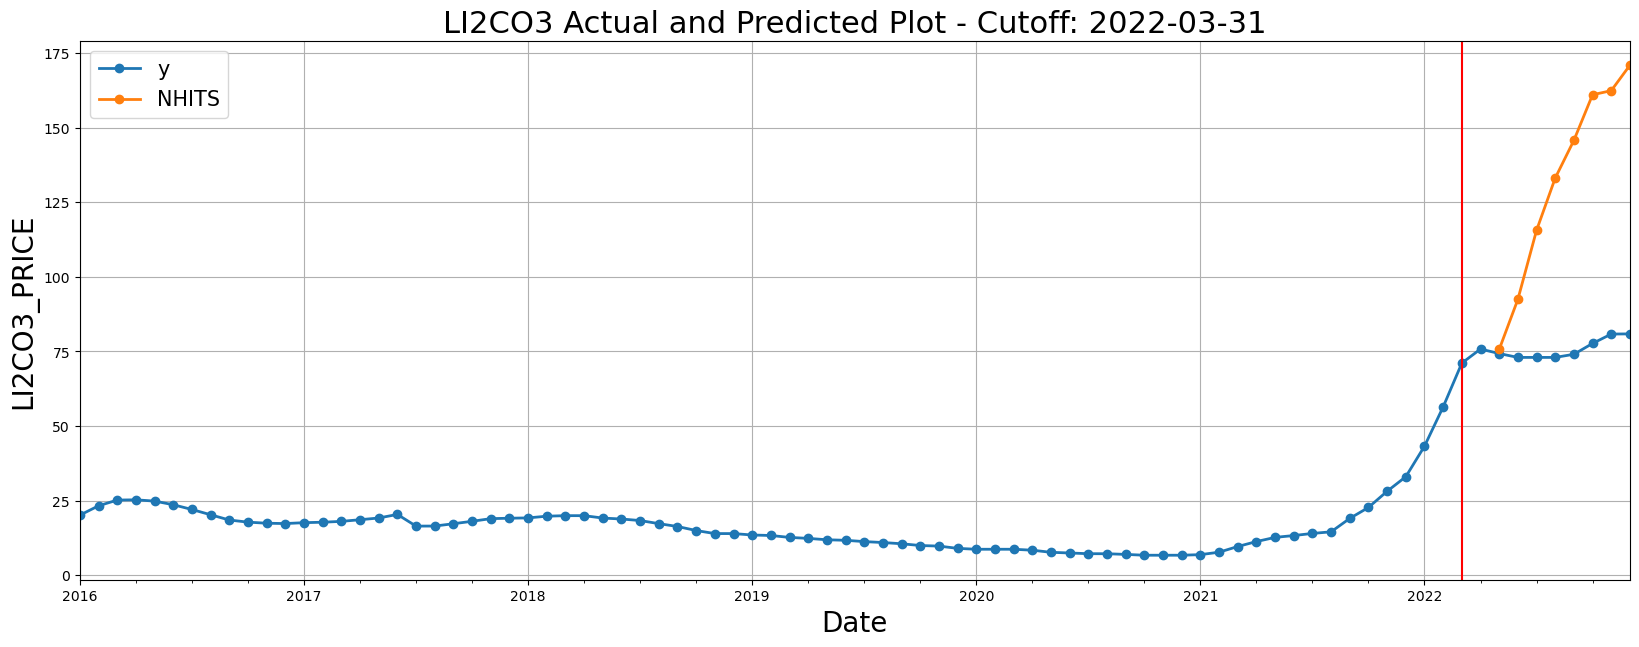

In [199]:
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df_nv = Y_test_df.merge(Y_hat_df_nv, how='left', on=['unique_id', 'ds'])
plot_df_nv = pd.concat([Y_train_df, Y_hat_df_nv]).set_index('ds')

plot_df_nv[['y', 'NHITS']].plot(ax=ax, linewidth=2, marker='o')
plt.axvline(cutoff_date, color='red')

ax.set_title(f'LI2CO3 Actual and Predicted Plot - Cutoff: {cutoff_date}', fontsize=22)
ax.set_ylabel('LI2CO3_PRICE', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

fig.savefig(f'./data/forecast_plot_{cutoff_date}_nv.png')

In [167]:
plot_df_nv[['y', 'NHITS']].to_csv(f'./data/forecasting_{cutoff_date}_nv.csv',index=False)

#### Yes 변수

In [ ]:
horizon = len(Y_test_df)

models = [
          # NBEATS(input_size=5 * horizon, gpus = 1, h=horizon, max_epochs=100),
          # NBEATSx(h=12, input_size=24,
          #       # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #       gpus=1,
          #       scaler_type='robust',
          #       stat_exog_list = None,  
          #       futr_exog_list = futr_list,
          #       max_steps=100,
          #       # val_check_steps=10,
          #       # early_stop_patience_steps=2
          #      ),
          NHITS(input_size=5 * horizon, 
                h=horizon,
                gpus = 1,
                # stat_exog_list = None,
                # hist_exog_list=hist_var_list,
                futr_exog_list = futr_list,
                # n_blocks = [1, 1, 1],
                mlp_units = [[512, 512], [512, 512], [512, 512]],
                n_pool_kernel_size = [2, 2, 1],
                # n_freq_downsample=[24, 12, 1],
                scaler_type = 'standard',
                learning_rate=1e-4,
                pooling_mode = 'MaxPool1d',
                activation='ReLU',
                batch_size=128,
                random_seed=42,
                max_epochs=200
               ),
           # NHITS(
           #       h,
           #       input_size,
           #       futr_exog_list=None,
           #       hist_exog_list=None,
           #       stat_exog_list=None,
           #       stack_types: list = ['identity', 'identity', 'identity'],
           #       n_blocks: list = [1, 1, 1],
           #       mlp_units: list = [[512, 512], [512, 512], [512, 512]],
           #       n_pool_kernel_size: list = [2, 2, 1],
           #       n_freq_downsample: list = [4, 2, 1],
           #       pooling_mode: str = 'MaxPool1d',
           #       interpolation_mode: str = 'linear',
           #       dropout_prob_theta=0.0,
           #       activation='ReLU',
           #       loss=MAE(),
           #       learning_rate=0.001,
           #       batch_size=32,
           #       windows_batch_size: int = 1024,
           #       step_size: int = 1,
           #       scaler_type='identity',
           #       random_seed=1,
           #       num_workers_loader=0,
           #       drop_last_loader=False,
           #       **trainer_kwargs,
    
          # TFT(h=12, 
          #     input_size=5 * horizon,
          #     # hidden_size=20,
          #     #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
          #     learning_rate=0.005,
          #     stat_exog_list = None,
          #     futr_exog_list = futr_list,
          #     max_steps=100,
          #     gpus=1,
          #     # val_check_steps=10,
          #     # early_stop_patience_steps=10,
          #     scaler_type='robust',
          #     # windows_batch_size=None,
          #     enable_progress_bar=True),
             ]
nforecast = NeuralForecast(models=models, freq='M')
nforecast.fit(df=Y_train_df)
Y_hat_df = nforecast.predict(futr_df=futr_df).reset_index()

Epoch 0:  50%|██████████████▌              | 1/2 [00:00<00:00,  3.50it/s, loss=1.28, v_num=1415, train_loss_step=1.280]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|██▌  | 1/2 [00:00<00:00, 15.40it/s, loss=1.16, v_num=1415, train_loss_step=1.050, train_loss_epoch=1.280]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|██▌  | 1/2 [00:00<00:00, 13.64it/s, loss=1.11, v_num=1415, train_loss_step=1.010, train_loss_epoch=1.050]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|██▌  | 1/2 [00:00<00:00, 15.15it/s, loss=1.06, v_num=1415, train_loss_step=0.906, train_loss_epoch=1.010]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|████    | 1/2 [00:00<00:00, 16.20it/s, loss=1, v_num=1415, train_loss_step=0.754, train_loss_epoch=0.906]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|██  | 1/2 [00:00<00:00, 14.87it/s, loss=0.952, v_num=1415, train_loss_step=0.710, train_loss_epoch=0.754]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|██  | 1/2 [00:00<00:00, 14.76it/s, loss=0.919, v_num=1415, train_loss_step=0.723

In [ ]:
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

plot_df[['y', 'NHITS']].plot(ax=ax, linewidth=2, marker='o')

plt.axvline(cutoff_date, color='red')
ax.set_title(f'LI2CO3 Actual and Predicted Plot - Cutoff: {cutoff_date}', fontsize=22)
ax.set_ylabel('LI2CO3_PRICE', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

# fig1.savefig(f'./data/forecasting_{cutoff_date}.png', dpi=100)
fig.savefig(f'./data/forecast_plot_{cutoff_date}_wv.png')

In [ ]:
plot_df[['y', 'NHITS']].to_csv(f'./data/forecast_plot_{cutoff_date}_wv.csv',index=False)